# 🔎 Retrieval (and QG?) playground

In [2]:
import json, random
import matplotlib.pyplot as plt
from langchain_core.example_selectors import (
    MaxMarginalRelevanceExampleSelector,
    SemanticSimilarityExampleSelector,
)
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_community.retrievers import KNNRetriever
from IPython.display import display, Markdown, Latex
from sentence_transformers import CrossEncoder


## ⚙️ 0. Choose claim & docstore

In [3]:
random.seed(111)

In [22]:
random.randint(0, 500)


365

In [41]:
datapoint

{'claim': "For a cumulative 29 of Nigeria's 60 years of existence as a nation, they have been under military rule",
 'required_reannotation': False,
 'label': 'Supported',
 'justification': 'True',
 'claim_date': '1-10-2020',
 'speaker': 'President Muhammadu Buhari ',
 'original_claim_url': 'https://web.archive.org/web/20210118154309/https://www.channelstv.com/2020/10/01/nigeria-at-60-president-buharis-independence-anniversary-speech-full-text/',
 'fact_checking_article': 'https://web.archive.org/web/20210526202243/https://africacheck.org/fact-checks/reports/nigerias-population-economy-and-history-fact-checking-buharis-independence-day',
 'reporting_source': 'ChannelsTV',
 'location_ISO_code': 'NG',
 'claim_types': ['Numerical Claim'],
 'fact_checking_strategies': ['Numerical Comparison', 'Consultation'],
 'questions': [{'question': 'When did Nigeria become independent?',
   'answers': [{'answer': '1st October 1960',
     'answer_type': 'Extractive',
     'source_url': 'https://www.tho

In [29]:
CLAIM_ID = 213
datapoint = json.load(open("data/dev.json"))[CLAIM_ID]
claim = datapoint["claim"]
docstore = []
for line in open(f"data_store/output_dev/{CLAIM_ID}.json"):
    docstore.append(json.loads(line))

# print claim in markdown with some sample evidence
display(Markdown("### 🗯️ " + claim + " [" + datapoint["label"] + "]"))
# sample 3
for i in random.sample(range(len(docstore)), 3):
    newline = "\n"
    display(Markdown(f"**{docstore[i]['url']}**\n\n * {newline.join(docstore[i]['url2text'][:10])}"))

### 🗯️ For a cumulative 29 of Nigeria's 60 years of existence as a nation, they have been under military rule [Supported]

**https://sgp.fas.org/crs/row/RL33964.pdf**

 * Overview. Nigeria is Africa’s most populous country, largest economy, and leading oil 
producer. Successive U.S. Administrations have described the U.S.-Nigeria relationship 
as among the most important in sub-Saharan Africa: the country is the United States’ 
second-largest trading partner and third-largest destination for U.S. foreign direct 
investment in the region, and it routinely ranks among the top annual recipients of U.S. 
foreign aid globally. Nigeria plays a major political and economic role in Africa and 
wields influence regionally. Nigerians make up the largest African-born population in 
the United States, generating billions of dollars in annual remittance outflows. 
Governance. Nigeria has been a multiparty democracy since 1999, after decades of 
military rule. Governance conditions have broadly improved over the past two decades, yet corruption, ethno-

**https://unstats.un.org/unsd/gender/Finland_Oct2016/Documents/Nigeria_paper.pdf**

 * MONITORING PARTICIPATION OF WOMEN IN POLITICS IN NIGERIA 
National Bureau of Statistics (NBS, Abuja, Nigeria) 
Nigeria has been recording low participation of women in both elective and appointive positions. This is a growing
concern to many Nigerians. However, concerted efforts have been made by government and non -governmental
organizations to increase the level of participation of women in politics in line with the declaration made at the
fourth World Conference on women in Beijing, which advocated 30% affirmative action. In Nigeria, the extant
National Gender Policy (NGP) recommended 35% affirmative action instead and sought for a more inclusive
representation of women with at least 35% of both elective political and appointive public service positions
respectively. The under representation of women in political participation gained root due to the patriarchal practice
inherent in our society, much of which were obvious from pre-colonial era till date. However, the re-introduction of

**https://www.reuters.com/article/idUSL21496329/**

 * 

### 🗂️ 0.1 Docstore formatting/scraping

In [30]:
# Naive version with \n concatenated url2texts:
documents = [
    Document(
        page_content=" ".join(doc["url2text"]),
        metadata={
            "url": doc["url"],
            # "sentences": doc["url2text"]
        },
    )
    for doc in docstore
]

TOKENS_PER_CHAR = 0.25
EMBEDDING_INPUT_SIZE = 512

chunks = []
for doc in docstore:
    buffer = ""
    for i, sentence in enumerate(doc["url2text"]):
        if (
            i == len(doc["url2text"]) - 1
            or len(buffer) + len(sentence) >= EMBEDDING_INPUT_SIZE / TOKENS_PER_CHAR
        ):
            context_before = ""
            if chunks and chunks[-1].metadata["url"] == doc["url"]:
                chunks[-1].metadata["context_after"] = buffer
                context_before = chunks[-1].page_content
            chunks.append(
                Document(
                    page_content=buffer,
                    metadata={"url": doc["url"], "context_before": context_before, "context_after": ""},
                )
            )

            buffer = ""
        buffer += sentence + " "
# chunk the documents into smaller pieces
chunks[random.randint(0, len(chunks))]

Document(metadata={'url': 'https://www.hrw.org/reports/1997/nigeria/Nigeria-10.htm', 'context_before': 'The Dutch government has also faced criticism for allowing a Nigerian delegation entry in March 1997, when the Netherlands, holding the presidency in the E.U., invited Nigeria to attend a meeting in Maastricht of government leaders from the fifteen-member E.U. bloc and its seventy acp partners. The European Parliament objected to the invitation, but the Dutch foreign ministry said that the visa restrictions only applied to "Nigerian authorities traveling to Europe for private reasons." A Dutch spokesman went on to say that the boycott was not intended to hinder important political discussions on the future relations between the acp and the E.U. The Dutch were of the opinions that "Nigeria is a very prominent member of the acp group: without Nigeria, the talks between the acp and the E.U. would be less significant."182 In November 1995, the United States broadened pre-existing restric

In [9]:
from utils.chat import  pretty_print

In [31]:
chid = -1

display(Markdown(chunks[chid].metadata["context_before"]))
display(Markdown(chunks[chid].page_content))
display(Markdown(chunks[chid].metadata["context_after"]))
chunks[chid].metadata["url"]

Dozens were killed and hundreds injured during clashes between protesters, riot police, and pro-Russian militia members. Yanukovych was eventually deposed as Ukrainian president before fleeing to Russia, at which point the scale of his corruption began to become apparent. In the wake of his ousting, protesters discovered that the former president had kept a 137-hectare mansion 20 miles outside Kiev, complete with its own golf-course, Spanish galleon, and ostrich farm. Mikheil Saakashvili, the former president of the Republic of Georgia, said that Yanukovych “would talk very loudly about how he had corrupted senior officials, in the supreme court and the constitutional court.” In 2016, investigators acquired a log book that showed that Yanukovych paid out more than $2 billion in bribes. Although he often declined to talk about his relationship with Yanukovych, Manafort’s financial records between him and other despots meant that these relationships weren’t exactly secrets. When it came to The Philippines’ former dictator Ferdinand Marcos, reports identified nearly $1 million flowing from the regime in Manila to Manafort’s firm, with Marcos specifically looking to Manafort and his colleagues to spin a democratic image out of his dictatorship. Mobutu Sese Seko, whose kleptocratic legacy still lingers throughout central Africa, also looked to Manafort’s team to hobnob in Washington, despite the fact that Mobutu was once described as the “archetypal African dictator” by TIME Magazine. Not to be outdone, Nigeria’s former autocrat Sani Abacha also turned to Manafort for public relations management. In addition to grave human rights violations, Abacha also appeared to be notably poor at hiding his ill-gotten gains, with the United States eventually freezing nearly a half-billion dollars in funds tied to Abacha and his family. And those are just the internationally recognized, and historically egregious, kleptocrats who Manafort helped to ravage their respective countries. 

Manafort also came to the aid of Jonas Savimbi, who was once described as the “murderous, demented Angolan rebel leader backed by the apartheid regime in South Africa.” Wrote The Daily Beast, “In his memoir, former Sen. Bill Bradley credited Savimbi’s lobbying team with lengthening” the Angolan Civil war. There are plenty of other brutal, autocratic regimes tied to Manafort’s past dealings, from the former Bakiyev regime in Kyrgyzstan – which used one of the shell companies now linked to Manafort – to Teodoro Obiang Nguema, who currently boasts the longest-tenured dictatorship in Africa. But at a certain point, listing Manafort’s list of the world’s most kleptocratic, most dictatorial, most brutal clients becomes redundant – and his proximity to the types of financial evasion of which he’s now accused become more than evident. And all of this was perfectly clear before Trump ever brought him aboard – and before he became yet another member of Trump’s campaign team now facing federal charges. 

'https://archive.thinkprogress.org/manaforts-former-clientele-27b927f175c7/'

In [32]:
from langchain_community.retrievers import BM25Retriever

retriever = BM25Retriever.from_documents(
    chunks, k=2500
)
chunks_pruned = retriever.invoke(claim)

### 📊 Docstore hist & truncation

In [12]:
len(chunks)

26427

(array([2.8000e+01, 5.0000e+01, 6.6000e+01, 6.5000e+01, 4.4000e+01,
        4.0000e+01, 4.3000e+01, 5.3000e+01, 3.4000e+01, 4.9000e+01,
        6.4000e+01, 5.3000e+01, 4.4000e+01, 5.8000e+01, 5.6000e+01,
        5.7000e+01, 6.4000e+01, 7.8000e+01, 7.4000e+01, 6.8000e+01,
        8.1000e+01, 8.3000e+01, 9.6000e+01, 9.4000e+01, 1.1700e+02,
        1.5500e+02, 1.6400e+02, 2.2600e+02, 2.8200e+02, 5.2500e+02,
        1.0130e+03, 2.2180e+03, 5.7060e+03, 1.2468e+04, 1.9330e+03,
        1.3000e+01, 1.7000e+01, 7.0000e+00, 1.0000e+01, 8.0000e+00,
        5.0000e+00, 1.0000e+00, 3.0000e+00, 5.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 0.0000e+00, 5.0000e+00, 1.0000e+00]),
 array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
         540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
        1080., 1140., 1200., 1260., 1320., 1380., 1440., 1500., 1560.,
        1620., 1680., 1740., 1800., 1860., 1920., 1980., 2040., 2100.,
        2160., 2220., 2280., 2340.

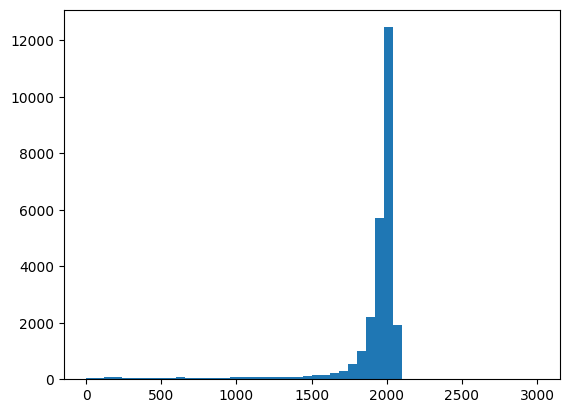

In [11]:
# histogram of sentences len, between 0 and 100
plt.hist([len(doc.page_content) for doc in chunks], bins=50, range=(0, 3000))

(array([2.4000e+01, 2.3000e+01, 2.9000e+01, 2.2000e+01, 1.9000e+01,
        2.2000e+01, 1.6000e+01, 3.4000e+01, 2.4000e+01, 2.5000e+01,
        1.9000e+01, 2.1000e+01, 3.2000e+01, 1.8000e+01, 1.9000e+01,
        3.1000e+01, 2.1000e+01, 2.5000e+01, 2.9000e+01, 2.3000e+01,
        2.4000e+01, 1.3000e+01, 2.0000e+01, 1.6000e+01, 2.0000e+01,
        1.7000e+01, 2.0000e+01, 3.5000e+01, 6.5000e+01, 1.1800e+02,
        3.3200e+02, 8.7800e+02, 5.4460e+03, 2.0798e+04, 3.3330e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
         540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
        1080., 1140., 1200., 1260., 1320., 1380., 1440., 1500., 1560.,
        1620., 1680., 1740., 1800., 1860., 1920., 1980., 2040., 2100.,
        2160., 2220., 2280., 2340.

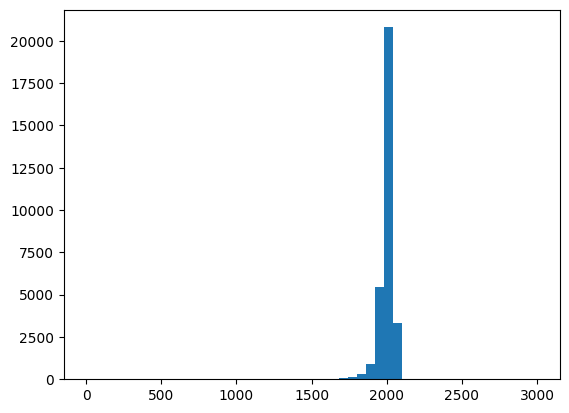

In [89]:
# histogram of sentences len, between 0 and 100
plt.hist([len(doc.page_content) for doc in chunks], bins=50, range=(0, 3000))

In [108]:
# show doc with most sentences
max_sentences = max(documents, key=lambda d: len(d.metadata["sentences"]))
max_sentences.metadata["url"]
max_sentences.page_content[:1000]

"Full text is available to Purdue University faculty, staff, and students on campus through this site.\nOff-campus Purdue users may download theses and dissertations by logging into the Libraries' proxy server with your Purdue Career Account.\nLinks to log in to the proxy server directly below the download button of each thesis or dissertation page.\nNon-Purdue users, may purchase copies of theses and dissertations from ProQuest or talk to your librarian about borrowing a copy through Interlibrary Loan.\n(Some titles may also be available free of charge in our Open Access Theses and Dissertations Series, so please check there first.)\nFortney, Sarah Katherine (2024) The Role of Trait and Specific Expectations in the Experience of Dysmenorrhea\nAbdullah, Umm E. Hani (2023) Exploratory Study of Deep Brain Stimulation in the Syngap1+/- Mouse Model of Autism Spectrum Disorder Using Electrophysiology\nAbney, Douglas John (2023) Broadband’s Role in Agricultural Job Postings In U.S. Counties\

In [110]:
# trim document page contents to 13000 characters
for doc in documents:
    doc.page_content = doc.page_content[:13000]

## 📐 1. Embedding searches

In [90]:
embeddings = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")

In [112]:
reranker = KNNRetriever.from_documents(documents, embeddings, k=10)
results = reranker.get_relevant_documents(claim)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + "*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1*



**https://www.nzherald.co.nz/nz/judith-collins-accused-of-potential-conflict-of-interest/NXKZLIY4IZNGIN6GKTNQZQSJWQ/**

Justice Minister Judith Collins has been accused of potentially breaching conflict of interest rules for Cabinet ministers after a visit to a company her husband is a director of while in China.
One News reported that while Ms Collins was in China last Oct

**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

Justice Minister Judith Collins said she told milk product company Oravida that it could not use her photograph or name to endorse its products prior to visiting it in China last year and although its milk was "nice" that was not an endorsement of the comp

**https://eitr545824759.wordpress.com/2020/08/08/judith-collins-david-wong-tung-and-the-oravida-kauri-ltd-ruakaka-connection-and-that-broken-marsden-point-fuel-line-breakage-that-caused-nz-48m-in-economic-damage-no-one-has-subsequently-been-charged/**

David Wong-Tung, the husband of then energy minister Judith Collins, was a director of Kauri Ruakaka until 2017, but is no longer on its board.
Former Engineering NZ president Elena Trout who headed the inquiry, said it understood the contractor sold swamp

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars.
Oravida pays about $500 a year to draw up

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

When Judith wasn’t questionably meeting Chinese border officials or diverting to its trade events, Oravida also exported swamp Kauri.
The above quote was when Judith was challenged that Oravida was damaging the environment.
What a sad day for Judith, appar

**https://www.newshub.co.nz/home/money/2016/04/oravida-jumps-in-to-export-kiwi-water.html**

New Zealand water could be the next big export to China and one of the companies that has just jumped in for a slice of the pie is none other than Oravida.
The company is only paying a small amount to the council for the millions of litres it can take.
Sto

**https://thedailyblog.co.nz/2014/03/05/crusher-collins-conflict-of-interest-seems-as-large-as-her-interest-in-conflict/**

Collins says Oravida visit not conflict of interest
Judith Collins went on a taxpayer-funded visit to China last year. In her public role as Justice Minister, she was there to talk about our system.
But she was also welcomed into a New Zealand export compa

**https://www.newshub.co.nz/home/new-zealand/2015/10/greens-mp-apologises-over-swamp-kauri-claim.html**

A Green MP has apologised to Judith Collins' husband following a press release condemning the extraction of valuable swamp kauri.
In a statement released by the party's conservation spokeswoman Eugenie Sage in June, she called for the illegal export of anc

**https://www.odt.co.nz/business/nz-milk-fetches-big-bucks-china**

You are not permitted to download, save or email this image. Visit image gallery to purchase the image.
But the high-price reflects a more complicated supply chain - and the degree to which the high-quality product is sought after in China.
It's just one o

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.”
So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

## 📐 Max. Marginal relevance


In [92]:
%pip install --upgrade --quiet  rank_bm25

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You should consider upgrading via the '/home/ullriher/venvs/averitec/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [108]:
from langchain_community.retrievers import BM25Retriever

retriever = BM25Retriever.from_documents(
    chunks, k=1500
)
chunks_pruned = retriever.invoke(claim)

In [109]:
len(chunks_pruned)

1500

In [110]:
chroma = Chroma(f"dev_{CLAIM_ID}_mxbai", persist_directory=f"data_store/vector_store_dev/{CLAIM_ID}")
chroma.delete_collection()
documents_ = [doc.copy() for doc in chunks_pruned]
for doc in documents_:
    if 'sentences' in doc.metadata:
        doc.metadata.pop("sentences", None)
    
chroma = chroma.from_documents(documents_, embeddings)


In [106]:
# make or overwrite /home/ullriher/aic_averitec/data_store/vector_store_dev/CLAIM_ID and persist chroma there
!mkdir -p /home/ullriher/aic_averitec/data_store/vector_store_dev/{CLAIM_ID}
chroma(f"/home/ullriher/aic_averitec/data_store/vector_store_dev/{CLAIM_ID}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


AttributeError: 'Chroma' object has no attribute 'persist'

In [114]:
claim

'New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.'

In [14]:
embeddings = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")

In [15]:
len(chunks_pruned)

2500

In [35]:
from langchain_community.vectorstores import FAISS

db = FAISS.from_documents(chunks_pruned, embeddings)
db.save_local(f"data_store/vector_store_dev/{CLAIM_ID}")

In [46]:
from utils.chat import SimpleJSONChat

chat = SimpleJSONChat(
    model="gpt-4o",
    system_prompt=f"""Pretend you are a researcher who receives a claim where your goal is to be as unbiased as possible. There are two teams: Query Generation (your team) and Information Acquisition. The goal of your team is to generate pertinent queries based on the claim such that when queried on Google/Bing, the results will be accurate and helpful in finding relevant sources. The second team then uses those sources to further refine whether the claim is supported (true), unsupported (false), or cherry picked (conflicting evidence). In summary, you will receive a claim and the task is to generate 10 queries that are relevant to the claim, paying mind to the different possible labels (i.e ensure the generated queries cover all possible labels). A necessary requirement is to include metadata like claim date, speaker, and reporting source. Use your imagination and take time to be thoughtful with queries, ensuring relevance to the claim. The queries should be formatted in a manner ready for querying via Google/Bing API, so no need for extra text or explanations intended for a user.""",
    parse_output=False,
)

In [43]:
datapoint

{'claim': "For a cumulative 29 of Nigeria's 60 years of existence as a nation, they have been under military rule",
 'required_reannotation': False,
 'label': 'Supported',
 'justification': 'True',
 'claim_date': '1-10-2020',
 'speaker': 'President Muhammadu Buhari ',
 'original_claim_url': 'https://web.archive.org/web/20210118154309/https://www.channelstv.com/2020/10/01/nigeria-at-60-president-buharis-independence-anniversary-speech-full-text/',
 'fact_checking_article': 'https://web.archive.org/web/20210526202243/https://africacheck.org/fact-checks/reports/nigerias-population-economy-and-history-fact-checking-buharis-independence-day',
 'reporting_source': 'ChannelsTV',
 'location_ISO_code': 'NG',
 'claim_types': ['Numerical Claim'],
 'fact_checking_strategies': ['Numerical Comparison', 'Consultation'],
 'questions': [{'question': 'When did Nigeria become independent?',
   'answers': [{'answer': '1st October 1960',
     'answer_type': 'Extractive',
     'source_url': 'https://www.tho

In [47]:
claim

"For a cumulative 29 of Nigeria's 60 years of existence as a nation, they have been under military rule"

In [48]:
res = chat(claim+f" (Speaker: {datapoint['speaker']}, {datapoint['claim_date']})")
res

'1. "Nigeria military rule duration history"\n2. "Total years of military rule in Nigeria"\n3. "Nigeria military rule timeline"\n4. "Nigeria military coups history"\n5. "Nigeria civilian vs military rule years"\n6. "President Muhammadu Buhari military rule statement 1-10-2020"\n7. "Nigeria 60 years independence military rule"\n8. "Nigeria military regimes list"\n9. "Nigeria military rule impact on governance"\n10. "Nigeria military rule periods and leaders"'

In [50]:
def parse(res):
    result = []
    lines = res.strip().split("\n")

    # Parse each line to extract the content
    parsed_results = [line.split(". ")[1].strip('"') for line in lines]

    # Print the parsed results
    for item in parsed_results:
        result.append(item)
    return result

In [54]:
for query in parse(res):
    results = db.similarity_search(query, 3)

    display(Markdown("### 🔎 " + query))
    display(Markdown("*Retrieved by " + embeddings.model_name + " similarity*\n\n"))
    # sample 3
    for r in results:
        newline = "\n"
        display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content}"))

### 🔎 Nigeria military rule duration history

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 similarity*



**https://arch.library.northwestern.edu/concern/generic_works/bv73c045f?locale=en**

Principles and Practices of Nigerian Military GovernmentPublic Deposited In this article, a Nigerian military system of governance is explicated. It was the dominant mode of governance in Nigeria until civilian rule was restored in 1999, initially under a former military ruler. Starting from the first military coup in January 1966, Nigeria experienced over 33 years of this system, with one civilian interregnum (1979-1983). Although touted as “corrective” regimes, what transpired in Nigeria was the evolution and entrenchment of a particular mode of governing with implicit and explicit principles and practices. Like the colonial system which it replicated, these bouts of military rule profoundly influenced the structure and character of the Nigerian polity. 

**https://www.encyclopedia.com/places/africa/nigeria-political-geography/nigeria**

Nigeria gained its independence from the United Kingdom on October 1, 1960, inheriting a parliamentary representative government from the British. The military came to power in a coup d'etat in 1966 and suspended the constitution until civilian rule was restored in 1979. Nigeria's 1979 Constitution called for a government closely resembling that of the U.S., with a president and vice president elected every 4 years, a bicameral legislature, and an independent judiciary. The military returned to power in 1983 and suspended all sections of the 1979 Constitution relating to electoral and legislative procedures at both the federal and state level. Ruling by decree, the military government announced in 1987 a program for Nigeria's transition back to civilian rule. The regime conducted local government, state government, and national assembly elections, and civilians took over the positions. On June 12, 1993, Nigerians went to the polls to elect a civilian president and complete the last leg of the military's carefully orchestrated transition program. Though most observers described the election as the fairest in Nigeria's history, the regime quickly annulled the poll, provoking a protracted political crisis that continues today. To try to address growing political turmoil, the regime stepped down and turned over power to a civilian-led Interim National Government (ING). The ING proved unable to tackle Nigeria's continuing political and economic problems, and the military took over again on November 17, 1993. The new military regime quickly consolidated power, dissolved all democratic institutions, and replaced civilian governors with military officers. Under the military rule, the main decision making organ is the military provisional ruling council (PRC), which rules by decrees that have the force of law. The PRC oversees the 32-member Federal Executive Council composed of military officers and civilians, including several prominent politicians. 

**https://www.nigeriankenya.or.ke/index.php/nigeria-systems/nigeria-past-present-and-future**

During this First Republic, a parliamentary system of government was in operation. This lasted till January 1966. The first military intervention in Nigeria occurred in January 1966 when the civilian government was overthrown in a military coup. This effectively marked the beginning and succession of military governments in the nation's political history. Military-rule continued till 1979 when the then Head of State, General Olusegun Obasanjo handed over power to the civilian government of President Shehu shagari. In the second Republic of President Shehu shagari, Nigeria adopted the Presidential system of government with an Executive President as the Head of the Federal Government. The administration was in power until 1983 when it was overthrown in a coup and the military once again come into governance. Nigeria again witnessed another round of military governments until 1993 when General Ibrahim Babaginda the head of the military government, put in place an interim civilian administration charged with conducting elections. This interim administration lasted for only three months when it was replaced in a palace coup by the military. The new military administration was headed by General Sani Abacha. General Sani Abacha's Government ruled the country from 1993 to 1998 when the Head of State suddenly died in June 1998. It must be pointed out that during this particular regime, Nigeria faced tremendous opposition from the International Community over human rights abuses, culminating in Nigeria's suspension from the Commonwealth. Indeed, at this period, Nigeria was treated like a pariah nation, tolerated only by a few and abandoned by other countries, including her traditional allies like Britain and Canada. With the sudden death of General Abacha in June 1998 General Abdulsalami Abubakar headed the new military administration, and was immediately confronted with the Herculean task of drawing Nigeria back from the brink of collapse and restoring her image. 

### 🔎 Total years of military rule in Nigeria

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 similarity*



**https://arch.library.northwestern.edu/concern/generic_works/bv73c045f?locale=en**

Principles and Practices of Nigerian Military GovernmentPublic Deposited In this article, a Nigerian military system of governance is explicated. It was the dominant mode of governance in Nigeria until civilian rule was restored in 1999, initially under a former military ruler. Starting from the first military coup in January 1966, Nigeria experienced over 33 years of this system, with one civilian interregnum (1979-1983). Although touted as “corrective” regimes, what transpired in Nigeria was the evolution and entrenchment of a particular mode of governing with implicit and explicit principles and practices. Like the colonial system which it replicated, these bouts of military rule profoundly influenced the structure and character of the Nigerian polity. 

**https://www.encyclopedia.com/places/africa/nigeria-political-geography/nigeria**

Nigeria gained its independence from the United Kingdom on October 1, 1960, inheriting a parliamentary representative government from the British. The military came to power in a coup d'etat in 1966 and suspended the constitution until civilian rule was restored in 1979. Nigeria's 1979 Constitution called for a government closely resembling that of the U.S., with a president and vice president elected every 4 years, a bicameral legislature, and an independent judiciary. The military returned to power in 1983 and suspended all sections of the 1979 Constitution relating to electoral and legislative procedures at both the federal and state level. Ruling by decree, the military government announced in 1987 a program for Nigeria's transition back to civilian rule. The regime conducted local government, state government, and national assembly elections, and civilians took over the positions. On June 12, 1993, Nigerians went to the polls to elect a civilian president and complete the last leg of the military's carefully orchestrated transition program. Though most observers described the election as the fairest in Nigeria's history, the regime quickly annulled the poll, provoking a protracted political crisis that continues today. To try to address growing political turmoil, the regime stepped down and turned over power to a civilian-led Interim National Government (ING). The ING proved unable to tackle Nigeria's continuing political and economic problems, and the military took over again on November 17, 1993. The new military regime quickly consolidated power, dissolved all democratic institutions, and replaced civilian governors with military officers. Under the military rule, the main decision making organ is the military provisional ruling council (PRC), which rules by decrees that have the force of law. The PRC oversees the 32-member Federal Executive Council composed of military officers and civilians, including several prominent politicians. 

**https://www.refworld.org/docid/5278c70012.html**

Nigeria's political rights rating changed from 6 to 4 following the holding of free and largely fair local, legislative, and presidential elections. The country's civil liberties rating changed from 4 to 3 due to an easing of repression against journalists, human rights workers, and political opponents, and the release of a number of political prisoners. Fifteen years of military rule ended in May 1999, when Olusegun Obasanjo assumed power as Nigeria's president. His victory in the February elections, with 63 percent of the vote, did not represent an absolute departure from military rule, however, because Obasanjo himself is a former general; he led a military regime from 1976 to 1979. Nevertheless, his is Nigeria's only military ruler to have voluntarily handed over power to civilians. Obasanjo, who spent three years in prison under former military ruler Sani Abacha, quickly moved to keep the military in check. He purged the armed forces of several hundred senior officers and then announced plans to cut the military by 30,000, down from 80,000, over a period of four years. The military has ruled Nigeria for all but ten years since independence from Britain in 1960. Its generals and their backers argued that they were the only ones capable of keeping a lid on simmering tensions between Muslims and Christians, and among the 122 million people who constitute the country's 250 ethnic groups. The Hausa-Fulani from northern Nigeria have dominated the military and government since independence. The Yoruba and Igbo people and smaller groups of the south deeply resent this domination and what many see as exploitation of their far richer lands. The north is largely Muslim while the south is mainly Christian. With the easing of repression, ethnic and religious conflicts erupted violently in several areas of the country in 1999, leaving hundreds dead and displacing thousands. 

### 🔎 Nigeria military rule timeline

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 similarity*



**https://arch.library.northwestern.edu/concern/generic_works/bv73c045f?locale=en**

Principles and Practices of Nigerian Military GovernmentPublic Deposited In this article, a Nigerian military system of governance is explicated. It was the dominant mode of governance in Nigeria until civilian rule was restored in 1999, initially under a former military ruler. Starting from the first military coup in January 1966, Nigeria experienced over 33 years of this system, with one civilian interregnum (1979-1983). Although touted as “corrective” regimes, what transpired in Nigeria was the evolution and entrenchment of a particular mode of governing with implicit and explicit principles and practices. Like the colonial system which it replicated, these bouts of military rule profoundly influenced the structure and character of the Nigerian polity. 

**https://www.encyclopedia.com/places/africa/nigeria-political-geography/nigeria**

Nigeria gained its independence from the United Kingdom on October 1, 1960, inheriting a parliamentary representative government from the British. The military came to power in a coup d'etat in 1966 and suspended the constitution until civilian rule was restored in 1979. Nigeria's 1979 Constitution called for a government closely resembling that of the U.S., with a president and vice president elected every 4 years, a bicameral legislature, and an independent judiciary. The military returned to power in 1983 and suspended all sections of the 1979 Constitution relating to electoral and legislative procedures at both the federal and state level. Ruling by decree, the military government announced in 1987 a program for Nigeria's transition back to civilian rule. The regime conducted local government, state government, and national assembly elections, and civilians took over the positions. On June 12, 1993, Nigerians went to the polls to elect a civilian president and complete the last leg of the military's carefully orchestrated transition program. Though most observers described the election as the fairest in Nigeria's history, the regime quickly annulled the poll, provoking a protracted political crisis that continues today. To try to address growing political turmoil, the regime stepped down and turned over power to a civilian-led Interim National Government (ING). The ING proved unable to tackle Nigeria's continuing political and economic problems, and the military took over again on November 17, 1993. The new military regime quickly consolidated power, dissolved all democratic institutions, and replaced civilian governors with military officers. Under the military rule, the main decision making organ is the military provisional ruling council (PRC), which rules by decrees that have the force of law. The PRC oversees the 32-member Federal Executive Council composed of military officers and civilians, including several prominent politicians. 

**https://www.nigeriankenya.or.ke/index.php/nigeria-systems/nigeria-past-present-and-future**

During this First Republic, a parliamentary system of government was in operation. This lasted till January 1966. The first military intervention in Nigeria occurred in January 1966 when the civilian government was overthrown in a military coup. This effectively marked the beginning and succession of military governments in the nation's political history. Military-rule continued till 1979 when the then Head of State, General Olusegun Obasanjo handed over power to the civilian government of President Shehu shagari. In the second Republic of President Shehu shagari, Nigeria adopted the Presidential system of government with an Executive President as the Head of the Federal Government. The administration was in power until 1983 when it was overthrown in a coup and the military once again come into governance. Nigeria again witnessed another round of military governments until 1993 when General Ibrahim Babaginda the head of the military government, put in place an interim civilian administration charged with conducting elections. This interim administration lasted for only three months when it was replaced in a palace coup by the military. The new military administration was headed by General Sani Abacha. General Sani Abacha's Government ruled the country from 1993 to 1998 when the Head of State suddenly died in June 1998. It must be pointed out that during this particular regime, Nigeria faced tremendous opposition from the International Community over human rights abuses, culminating in Nigeria's suspension from the Commonwealth. Indeed, at this period, Nigeria was treated like a pariah nation, tolerated only by a few and abandoned by other countries, including her traditional allies like Britain and Canada. With the sudden death of General Abacha in June 1998 General Abdulsalami Abubakar headed the new military administration, and was immediately confronted with the Herculean task of drawing Nigeria back from the brink of collapse and restoring her image. 

### 🔎 Nigeria military coups history

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 similarity*



**https://www.marines.mil/Portals/1/Publications/Nigeria%20Study_3.pdf**

a malfunctioning political system. In Nigeria, which typifies the scenario just presented, military rule was usually seen as a "res- cue" operation necessary to save the country from civilian inepti- tude. Military rule was not expected to last long; once the rescue operation was complete, the military should return to the barracks where they belonged and leave the governing to civilian politicians. The problem, however, was that although military officers accepted this rationale, military rule usually became self-sustaining. From the onset of independent government in Nigeria in 1960 to the end of 1990, the military had ruled for twenty-one years. Altogether there were five coups d'etat involving changes of govern- ment: those of January 15, 1966; July 29, 1966; July 29, 1975; December 31, 1983; and August 27, 1985. There was also an un- successful coup in which the head of state, General Murtala Mu- hammad, was killed in February 1976, and another that was nipped in the bud in December 1985. An attempt to overthrow General Ibrahim Babangida was made in April 1990. Of these coups, only those of January 1966 and December 1983 were against civilian governments. Several explanations of military intervention have been added to those given by the coup plotters themselves. Whereas the latter have cited economic mismanagement and corruption, other explanations have ranged from the continuation of ethno- regional politics by military means to the personal ambitions of At the time a disparate group of junior officers struck first in January 1966, the officers were still politically naive and had yet to master the art of coup planning and execution. This inexperience partly explains why Major Kaduna Nzeogwu and others who masterminded the coup failed to take over state power. Instead, Major General Johnson Aguiyi Ironsi, commander in chief of the army, became Nigeria's first military ruler. Some of the remote causes of the coup included the use of soldiers to quell unrest, such 

**https://www.bbc.com/news/world-africa-35312370**

Although most of Nigeria's current population of about 170 million was not born when the country's first coup was staged 50 years ago, its legacy lingers on, writes Nigerian historian and author Max Siollun. On 15 January 1966, a group of young, idealistic, UK-trained army majors overthrew Nigeria's democratic government in a violent military coup. The coup leaders described it as a brief and temporary revolution to end corruption and ethnic rivalry. The coup exposed the vulnerability of the Nigerian state, and how simple it was to use soldiers to attack the government, rather than protect it. A succession of increasingly repressive military governments ruled Nigeria for 29 of the next 33 years, until the restoration of democracy in 1999. Here are four ways in which Nigeria - Africa's most populous state and leading oil producer - is still affected by the events of 1966: Protesters in south-east Nigeria have recently demanded the region's secession from Nigeria and the formation of a new country called Biafra. The Biafra movement's origins can be traced back to the January 1966 coup. The officers who staged the coup were mostly Christian southerners from the Igbo ethnic group, and they assassinated several northerners, including the four highest-ranking northern army officers, Prime Minister Tafawa Balewa, and Northern Region Premier Ahmadu Bello (both Muslims from the north). Army commander Major-General Johnson Aguiyi-Ironsi, an Igbo, suppressed the coup, but seized power himself. Northerners interpreted the coup as an Igbo-led conspiracy to subjugate the north and impose Igbo domination. Six months later, northern soldiers staged another even bloodier counter-coup against their Igbo colleagues. Northern mobs killed around 30,000 Igbos, and Igbos fled south, and in the following year sought to form a new breakaway country called Biafra. Northerners living in Igbo areas were also killed in revenge attacks. 

**https://www.hrw.org/report/2007/10/11/criminal-politics/violence-godfathers-and-corruption-nigeria**

Their coup failed and the lead plotters were arrested, but the prime minister and other key government figures were murdered in the attempt.[8] General Johnson Aguiyi-Ironsi, an ethnic Igbo, was soon "invited" by the tattered remains of Nigeria's civilian government to step into the resulting power vacuum and became Nigeria's first military head of state. Many Nigerians initially welcomed the military's 1966 takeover, hoping it would bring law and order along with more honest and effective government.[9] The military retained power from 1966 until 1979 but this was not a period of stability or peace. Ironsi was murdered in a successful coup after less than seven months in office by a group of northern military officers. His death was followed by ethnic rioting across Nigeria that helped precipitate Nigeria's horrific Biafran civil war.[10] After the civil war ended in 1970, Nigeria's ruling military continued to be wracked with violent power struggles. Aside from Ironsi's murder the country saw one other head of state ousted in a coup and a third murdered in an attempted coup before the discredited military returned power to civilian hands in 1979.[11] The head of state who organized that transition was General Olusegun Obasanjo, who would return to power as a civilian leader twenty years later, in 1999. The civilian government under President Shehu Shagari that was elected to office in 1979 was in place for only four years. Shagari's administration, which initially had the blessing of Nigeria's military establishment, was blamed for widespread corruption at both the federal and state levels, deepening levels of poverty and internecine political warfare that led ultimately to the electoral debacle of 1983. The elections organized that year were massively rigged in favor of Shagari and his National Party of Nigeria. 

### 🔎 Nigeria civilian vs military rule years

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 similarity*



**https://www.encyclopedia.com/places/africa/nigeria-political-geography/nigeria**

Nigeria gained its independence from the United Kingdom on October 1, 1960, inheriting a parliamentary representative government from the British. The military came to power in a coup d'etat in 1966 and suspended the constitution until civilian rule was restored in 1979. Nigeria's 1979 Constitution called for a government closely resembling that of the U.S., with a president and vice president elected every 4 years, a bicameral legislature, and an independent judiciary. The military returned to power in 1983 and suspended all sections of the 1979 Constitution relating to electoral and legislative procedures at both the federal and state level. Ruling by decree, the military government announced in 1987 a program for Nigeria's transition back to civilian rule. The regime conducted local government, state government, and national assembly elections, and civilians took over the positions. On June 12, 1993, Nigerians went to the polls to elect a civilian president and complete the last leg of the military's carefully orchestrated transition program. Though most observers described the election as the fairest in Nigeria's history, the regime quickly annulled the poll, provoking a protracted political crisis that continues today. To try to address growing political turmoil, the regime stepped down and turned over power to a civilian-led Interim National Government (ING). The ING proved unable to tackle Nigeria's continuing political and economic problems, and the military took over again on November 17, 1993. The new military regime quickly consolidated power, dissolved all democratic institutions, and replaced civilian governors with military officers. Under the military rule, the main decision making organ is the military provisional ruling council (PRC), which rules by decrees that have the force of law. The PRC oversees the 32-member Federal Executive Council composed of military officers and civilians, including several prominent politicians. 

**https://arch.library.northwestern.edu/concern/generic_works/bv73c045f?locale=en**

Principles and Practices of Nigerian Military GovernmentPublic Deposited In this article, a Nigerian military system of governance is explicated. It was the dominant mode of governance in Nigeria until civilian rule was restored in 1999, initially under a former military ruler. Starting from the first military coup in January 1966, Nigeria experienced over 33 years of this system, with one civilian interregnum (1979-1983). Although touted as “corrective” regimes, what transpired in Nigeria was the evolution and entrenchment of a particular mode of governing with implicit and explicit principles and practices. Like the colonial system which it replicated, these bouts of military rule profoundly influenced the structure and character of the Nigerian polity. 

**https://kids.britannica.com/students/article/Nigeria/276094**

Following the 1967 civil war, Nigeria was ruled largely by military governments. Power was seized by General Yakubu Gowon, who ruled Nigeria until 1975, when he was deposed by a military coup. After a short series of power struggles among other leaders, the reins of the country were passed in 1976 to General Olusegun Obasanjo. Three years later, Obasanjo led Nigeria to a civilian government based on a constitution adopted in 1978. This document formally established Nigeria once again as a federal republic, with a system of government modeled after the United States. Nigeria’s state system was developed in an attempt to give rights to local peoples while keeping a strong central government. The first civilian elections in decades were held in 1979. Nigerians elected Shehu Shagari, a leader of the right-wing National Party of Nigeria. During his tenure as president, the government was marred by enormous political corruption, waste, and abuse. Shagari was reelected to a second term in 1983 but was ousted later that year in a military coup led by Muhammadu Buhari. Buhari was himself replaced two years later in a bloodless coup by Ibrahim Babangida, another member of the military. Although Babangida presented himself as a considerate leader, the public demand for a return to civilian rule could not be ignored. Free elections were held in 1993, and a civilian, Moshood Abiola, was declared the winner. However, the election results were voided immediately by Babangida’s government. This move sparked widespread civil unrest, forcing Babangida to resign as president. Power was handed over to a nonelected interim civilian government. Within months the military, led by General Sani Abacha, had seized control of the country. Abacha abandoned the economic reforms of his predecessors. He had Abiola arrested and jailed on charges of treason in June 1994. He also imprisoned Obasanjo, the former military leader. 

### 🔎 President Muhammadu Buhari military rule statement 1-10-2020

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 similarity*



**https://www.cnn.com/2015/03/31/africa/nigeria-muhammadu-buhari/index.html**

Muhammadu Buhari is a 72-year-old retired major general from Daura, northern Nigeria Buhari led Nigeria from 1983 to 1985, coming to power and leaving power through coups Against a backdrop of violence in the North, he has vowed to make security a priority Muhammadu Buhari has ruled Nigeria before, as one of a line of military strongmen who dominated the country between 1966 and 1999. A military coup brought Buhari to power in late 1983 – closing a brief period of popular rule by Shehu Shagari – and another military coup ousted him from power in August 1985. Buhari’s 20-month rule was known for what he described as a “war on indiscipline,” a tough regime which some say was marred by human rights abuses. The 72-year-old retired major general’s experience as a military ruler has been viewed as a plus by some and a minus by others in present-day Nigeria, where the government has been locked in a deadly battle with the militant group Boko Haram. This year alone, the extremists have killed at least 1,000 civilians, Human Rights Watch says. The ongoing violence in the Northeast has put security – along with corruption and the economy – at the top of the election agenda. Prior to this year’s polls in March, Ayo Johnson, a documentary filmmaker and analyst on African affairs, told CNN that voters would opt for whoever could make Nigeria feel safe. “Many Nigerians will not forget (Buhari) was a military leader, during a dictatorship,” Johnson said. “Or maybe they will feel that they need a military leader to address fundamental problems such as terrorism.” Buhari has campaigned as a born-again democrat to allay fears about his strict military regime, while stressing that Nigeria’s security needs to be the next government’s focus. “It’s a question of security. Whether I was a former military officer or a politician through and through, when there is insecurity of this scale in the country, that takes the priority,” he said from his campaign plane. 

**https://www.refworld.org/docid/3ae6a82e0.html**

This administration will notallow lawlessness and anarchy to camouflage as right or freedom. We will notaccept brazen challenge to the State authority under threat of violence asrecently happened in the Niger Delta region. Government has a responsibility tosafeguard the state and the security of life and property of all its citizensand those of foreign nationals on our soil carrying out their legitimatepre-occupations. This administration is resolved to do just that. I will,therefore appeal to all those that have been engaged in the unacceptableexcesses of the recent past in the region to stop such actions henceforth, inthe interest of peace and decency. This administration is convinced that theNiger Delta region stands to reap tremendous dividend by dissent throughdialogue rather than dissent through violence. Such is the path to a civilizedand great society which we are all striving to build.[441][441] As this report went to press reports reached Human RightsWatch that more than one hundred people had been killed in and around Kaiama,Bayelsa State, a sizeable Ijaw community accessible by road, by soldiers overthe new year weekend. Some of these youths had reported been killed inconfrontations with the military; some had been summarily executed in searchesof vehicles or homes. Ten to twenty houses were reported to have been burntdown, and the community left deserted. Further disturbances took place inOkpoma, near Shell's Forcados terminal on the Atlantic coast.[442][442] Thesimple presence of the security forces posted to guard oil productionfacilities causes communities to face additional harassment and extortion,beyond that to which all Nigerians are subjected by the military regimes whichhave ruled Nigeria for all but ten years since independence. Ordinary communitymembers with the misfortune to have farms or fishing grounds near an oilfacility may be subjected to daily harassment from security guards as they goabout their work. 

**https://www.channelstv.com/2020/02/17/president-buhari-is-breaking-the-law-falana/**

Human rights lawyer, Femi Falana on Monday said President Muhammadu Buhari is running afoul of the law in his decision not to terminate the current crop of security Service Chiefs. Mr Falana, who appeared on Sunrise Daily, argued that the laws regulating military officers require the retirement of military officers who have served for 35 years or have reached the age of 60. He added that a lawsuit would be filed this week in respect of the matter. In an interview that lasted more than 20 minutes, Mr Falana also said President Buhari “must be prevailed upon” to acknowledge the possibility of “internal sabotage” within the military in the war against insurgency. READ ALSO: Presidency Has No Power To Stop Peaceful Protests – Falana Responding to statements from the Presidency cautioning against public protests against the government, Mr Falana said such comments should be “embarrassing” to the President who, before he took the country’s reins, had led public demonstrations. “Under the public service rule, under the harmonised rules for military officers in Nigeria and under Section 6 of the armed forces act, which empowers the President to make rules and regulations for the military, there is no provision for extension of tenure (for Service Chiefs) beyond the period stipulated by law. It has been done in the past, but that does not make it right. There is equality before the law, so you can’t extend the service of certain officers while you ask others to go after 35 years of service or the attainment of 60 years of age. “To the best of my knowledge, a suit will be filed during the week, in respect of this matter. “The President must be prevailed upon to appreciate that we may also be undergoing what you might describe as internal sabotage (in the fight against insurgency) by many members of the armed forces who simply feel since these are the people who can stop insurgency or terrorism, let them go ahead. 

### 🔎 Nigeria 60 years independence military rule

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 similarity*



**https://www.encyclopedia.com/places/africa/nigeria-political-geography/nigeria**

Nigeria gained its independence from the United Kingdom on October 1, 1960, inheriting a parliamentary representative government from the British. The military came to power in a coup d'etat in 1966 and suspended the constitution until civilian rule was restored in 1979. Nigeria's 1979 Constitution called for a government closely resembling that of the U.S., with a president and vice president elected every 4 years, a bicameral legislature, and an independent judiciary. The military returned to power in 1983 and suspended all sections of the 1979 Constitution relating to electoral and legislative procedures at both the federal and state level. Ruling by decree, the military government announced in 1987 a program for Nigeria's transition back to civilian rule. The regime conducted local government, state government, and national assembly elections, and civilians took over the positions. On June 12, 1993, Nigerians went to the polls to elect a civilian president and complete the last leg of the military's carefully orchestrated transition program. Though most observers described the election as the fairest in Nigeria's history, the regime quickly annulled the poll, provoking a protracted political crisis that continues today. To try to address growing political turmoil, the regime stepped down and turned over power to a civilian-led Interim National Government (ING). The ING proved unable to tackle Nigeria's continuing political and economic problems, and the military took over again on November 17, 1993. The new military regime quickly consolidated power, dissolved all democratic institutions, and replaced civilian governors with military officers. Under the military rule, the main decision making organ is the military provisional ruling council (PRC), which rules by decrees that have the force of law. The PRC oversees the 32-member Federal Executive Council composed of military officers and civilians, including several prominent politicians. 

**https://www.encyclopedia.com/places/africa/nigeria-political-geography/nigeria**

Nigeria was granted full independence in October 1960, as a federation of three regions (northern, western, and eastern) under a constitution that provided for a parliamentary form of government. Under the constitution, each of the three regions retained a substantial measure of self-government. The federal government was given exclusive powers in defense and security, foreign relations, and commercial and fiscal policies. In October 1963, Nigeria altered its relationship with the United Kingdom by proclaiming itself a federal republic and promulgating a new constitution. A fourth region (the mid-west) was established that year. From the outset, Nigeria's ethnic, regional, and religious tensions were magnified by the significant disparities in economic and educational development between the south and the north. On January 15, 1966, a small group of army officers, mostly southeastern Igbos, overthrew the government and assassinated the federal prime minister and the premiers of the northern and western regions. The federal military government that assumed power was unable to quiet ethnic tensions or produce a constitution acceptable to all sections of the country. In fact, its efforts to abolish the federal structure greatly raised tensions and led to another coup in July. The coup related massacre of thousands of Igbo in the north prompted hundreds of thousands of them to return to the southeast, where increasingly strong Igbo secessionist sentiment emerged. In a move that gave greater autonomy to minority ethnic groups, the military divided the four regions into 12 states. The Igbo rejected attempts at constitutional revisions and insisted on full autonomy for the east. Finally, in May 1967, Lt. Col. Emeka Ojukwu, the military governor of the eastern region, who emerged as the leader of increasing Igbo secessionist sentiment, declared the independence of the eastern region as the "Republic of Biafra." The ensuing civil war was bitter and bloody, ending in the defeat of Biafra in 1970. 

**https://www.globalcitizen.org/en/content/facts-to-know-about-nigeria-independence/**

On Oct. 1, Nigeria celebrates its Diamond Jubilee — marking 60 years since the country became an independent nation with the end of colonial rule. With an estimated population of about 204 million people, Nigeria today is the most populous Black nation on Earth and the seventh most populous country in the world. There is so much to learn about Nigeria, its people, and its cultures. With so much history and cultural richness, there are many lessons to be learned from Nigeria’s impact on the African continent and the world at large. Global Citizen celebrates the resilience and ingenuity of the Nigerian people on this historic and important day. Here are 11 historical facts you should know about the country often referred to as the “Giant of Africa”: The land area known today as Nigeria was formed in 1914 when colonial authorities merged the Northern and Southern Protectorates of Nigeria, to form the amalgamated Protectorate and Colony of Nigeria. This merger brought together over 400 ethnic groups and tribes into what was then the largest British colony in the world. The name “Nigeria” is also derived from colonial sources. 2. Nigeria gained independence from colonial rule in 1960. Nigeria gained independence from the British empire in 1960, initially adopting a British style of government with Abubakar Tafawa Balewa as the first Nigerian head of government (prime minister). The country then had a population of over 45 million people. 3. Nigeria has been ruled by military leaders for a combined 29 years. On Jan. 15 1966, a group of young, idealistic, UK-trained army majors overthrew Nigeria's democratic government in a violent military coup — the country’s first. A succession of increasingly repressive military governments ruled Nigeria for 29 of the next 33 years, until the restoration of democracy in 1999. Some of the blowback effects of this coup include: - it propelled a group of young military officers onto the national stage and they still wield enormous influence in Nigerian politics; 

### 🔎 Nigeria military regimes list

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 similarity*



**https://arch.library.northwestern.edu/concern/generic_works/bv73c045f?locale=en**

Principles and Practices of Nigerian Military GovernmentPublic Deposited In this article, a Nigerian military system of governance is explicated. It was the dominant mode of governance in Nigeria until civilian rule was restored in 1999, initially under a former military ruler. Starting from the first military coup in January 1966, Nigeria experienced over 33 years of this system, with one civilian interregnum (1979-1983). Although touted as “corrective” regimes, what transpired in Nigeria was the evolution and entrenchment of a particular mode of governing with implicit and explicit principles and practices. Like the colonial system which it replicated, these bouts of military rule profoundly influenced the structure and character of the Nigerian polity. 

**https://www.encyclopedia.com/places/africa/nigeria-political-geography/nigeria**

Nigeria gained its independence from the United Kingdom on October 1, 1960, inheriting a parliamentary representative government from the British. The military came to power in a coup d'etat in 1966 and suspended the constitution until civilian rule was restored in 1979. Nigeria's 1979 Constitution called for a government closely resembling that of the U.S., with a president and vice president elected every 4 years, a bicameral legislature, and an independent judiciary. The military returned to power in 1983 and suspended all sections of the 1979 Constitution relating to electoral and legislative procedures at both the federal and state level. Ruling by decree, the military government announced in 1987 a program for Nigeria's transition back to civilian rule. The regime conducted local government, state government, and national assembly elections, and civilians took over the positions. On June 12, 1993, Nigerians went to the polls to elect a civilian president and complete the last leg of the military's carefully orchestrated transition program. Though most observers described the election as the fairest in Nigeria's history, the regime quickly annulled the poll, provoking a protracted political crisis that continues today. To try to address growing political turmoil, the regime stepped down and turned over power to a civilian-led Interim National Government (ING). The ING proved unable to tackle Nigeria's continuing political and economic problems, and the military took over again on November 17, 1993. The new military regime quickly consolidated power, dissolved all democratic institutions, and replaced civilian governors with military officers. Under the military rule, the main decision making organ is the military provisional ruling council (PRC), which rules by decrees that have the force of law. The PRC oversees the 32-member Federal Executive Council composed of military officers and civilians, including several prominent politicians. 

**https://www.refworld.org/docid/5278c70012.html**

Nigeria's political rights rating changed from 6 to 4 following the holding of free and largely fair local, legislative, and presidential elections. The country's civil liberties rating changed from 4 to 3 due to an easing of repression against journalists, human rights workers, and political opponents, and the release of a number of political prisoners. Fifteen years of military rule ended in May 1999, when Olusegun Obasanjo assumed power as Nigeria's president. His victory in the February elections, with 63 percent of the vote, did not represent an absolute departure from military rule, however, because Obasanjo himself is a former general; he led a military regime from 1976 to 1979. Nevertheless, his is Nigeria's only military ruler to have voluntarily handed over power to civilians. Obasanjo, who spent three years in prison under former military ruler Sani Abacha, quickly moved to keep the military in check. He purged the armed forces of several hundred senior officers and then announced plans to cut the military by 30,000, down from 80,000, over a period of four years. The military has ruled Nigeria for all but ten years since independence from Britain in 1960. Its generals and their backers argued that they were the only ones capable of keeping a lid on simmering tensions between Muslims and Christians, and among the 122 million people who constitute the country's 250 ethnic groups. The Hausa-Fulani from northern Nigeria have dominated the military and government since independence. The Yoruba and Igbo people and smaller groups of the south deeply resent this domination and what many see as exploitation of their far richer lands. The north is largely Muslim while the south is mainly Christian. With the easing of repression, ethnic and religious conflicts erupted violently in several areas of the country in 1999, leaving hundreds dead and displacing thousands. 

### 🔎 Nigeria military rule impact on governance

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 similarity*



**https://arch.library.northwestern.edu/concern/generic_works/bv73c045f?locale=en**

Principles and Practices of Nigerian Military GovernmentPublic Deposited In this article, a Nigerian military system of governance is explicated. It was the dominant mode of governance in Nigeria until civilian rule was restored in 1999, initially under a former military ruler. Starting from the first military coup in January 1966, Nigeria experienced over 33 years of this system, with one civilian interregnum (1979-1983). Although touted as “corrective” regimes, what transpired in Nigeria was the evolution and entrenchment of a particular mode of governing with implicit and explicit principles and practices. Like the colonial system which it replicated, these bouts of military rule profoundly influenced the structure and character of the Nigerian polity. 

**https://mazw.org.zw/military-rule-in-nigeria-1966-1975-history-impact-and-legacy/**

As law period Military Rule in Nigeria 1966 to 1975 fascinating complex topic. It is a time in Nigeria`s history that has left a significant impact on the country`s political and legal landscape. The period Military Rule in Nigeria 1966 to 1975 characterized political instability, human abuses, economic challenges. The civilian government 1966 led series coups counter-coups, dominance military leadership country nearly decade. During this era, Nigeria experienced several significant events, including the Nigerian Civil War, the establishment of military regimes, and the implementation of martial law. Events shaped political legal landscape country years come. The military rule during this period had a profound impact on Nigeria`s legal system. The rule of law was often undermined, and the judiciary was subject to interference by the military government. Human rights violations were rampant, and the legal framework was often used to suppress dissent and opposition. One notable case study period trial execution political leaders activists, raised concerns legitimacy fairness legal proceedings military rule. Lack due process denial basic rights accused common occurrences time. According historical data, period Military Rule in Nigeria 1966 to 1975 resulted significant decline country`s economic social indicators. The GDP growth rate plummeted, and poverty levels increased. Additionally, the number of human rights abuses and political repression cases rose during this time. Studying period Military Rule in Nigeria 1966 to 1975 reminds us fragility democracy importance upholding rule law. It serves as a stark reminder of the dangers of unchecked military power and the devastating impact it can have on a nation`s legal and political institutions. The era Military Rule in Nigeria 1966 to 1975 left lasting imprint country`s legal history. Period serves cautionary tale reminder need protect uphold principles democracy rule law. 

**https://www.encyclopedia.com/places/africa/nigeria-political-geography/nigeria**

Nigeria gained its independence from the United Kingdom on October 1, 1960, inheriting a parliamentary representative government from the British. The military came to power in a coup d'etat in 1966 and suspended the constitution until civilian rule was restored in 1979. Nigeria's 1979 Constitution called for a government closely resembling that of the U.S., with a president and vice president elected every 4 years, a bicameral legislature, and an independent judiciary. The military returned to power in 1983 and suspended all sections of the 1979 Constitution relating to electoral and legislative procedures at both the federal and state level. Ruling by decree, the military government announced in 1987 a program for Nigeria's transition back to civilian rule. The regime conducted local government, state government, and national assembly elections, and civilians took over the positions. On June 12, 1993, Nigerians went to the polls to elect a civilian president and complete the last leg of the military's carefully orchestrated transition program. Though most observers described the election as the fairest in Nigeria's history, the regime quickly annulled the poll, provoking a protracted political crisis that continues today. To try to address growing political turmoil, the regime stepped down and turned over power to a civilian-led Interim National Government (ING). The ING proved unable to tackle Nigeria's continuing political and economic problems, and the military took over again on November 17, 1993. The new military regime quickly consolidated power, dissolved all democratic institutions, and replaced civilian governors with military officers. Under the military rule, the main decision making organ is the military provisional ruling council (PRC), which rules by decrees that have the force of law. The PRC oversees the 32-member Federal Executive Council composed of military officers and civilians, including several prominent politicians. 

### 🔎 Nigeria military rule periods and leaders

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 similarity*



**https://arch.library.northwestern.edu/concern/generic_works/bv73c045f?locale=en**

Principles and Practices of Nigerian Military GovernmentPublic Deposited In this article, a Nigerian military system of governance is explicated. It was the dominant mode of governance in Nigeria until civilian rule was restored in 1999, initially under a former military ruler. Starting from the first military coup in January 1966, Nigeria experienced over 33 years of this system, with one civilian interregnum (1979-1983). Although touted as “corrective” regimes, what transpired in Nigeria was the evolution and entrenchment of a particular mode of governing with implicit and explicit principles and practices. Like the colonial system which it replicated, these bouts of military rule profoundly influenced the structure and character of the Nigerian polity. 

**https://www.nigeriankenya.or.ke/index.php/nigeria-systems/nigeria-past-present-and-future**

During this First Republic, a parliamentary system of government was in operation. This lasted till January 1966. The first military intervention in Nigeria occurred in January 1966 when the civilian government was overthrown in a military coup. This effectively marked the beginning and succession of military governments in the nation's political history. Military-rule continued till 1979 when the then Head of State, General Olusegun Obasanjo handed over power to the civilian government of President Shehu shagari. In the second Republic of President Shehu shagari, Nigeria adopted the Presidential system of government with an Executive President as the Head of the Federal Government. The administration was in power until 1983 when it was overthrown in a coup and the military once again come into governance. Nigeria again witnessed another round of military governments until 1993 when General Ibrahim Babaginda the head of the military government, put in place an interim civilian administration charged with conducting elections. This interim administration lasted for only three months when it was replaced in a palace coup by the military. The new military administration was headed by General Sani Abacha. General Sani Abacha's Government ruled the country from 1993 to 1998 when the Head of State suddenly died in June 1998. It must be pointed out that during this particular regime, Nigeria faced tremendous opposition from the International Community over human rights abuses, culminating in Nigeria's suspension from the Commonwealth. Indeed, at this period, Nigeria was treated like a pariah nation, tolerated only by a few and abandoned by other countries, including her traditional allies like Britain and Canada. With the sudden death of General Abacha in June 1998 General Abdulsalami Abubakar headed the new military administration, and was immediately confronted with the Herculean task of drawing Nigeria back from the brink of collapse and restoring her image. 

**https://www.encyclopedia.com/places/africa/nigeria-political-geography/nigeria**

Nigeria gained its independence from the United Kingdom on October 1, 1960, inheriting a parliamentary representative government from the British. The military came to power in a coup d'etat in 1966 and suspended the constitution until civilian rule was restored in 1979. Nigeria's 1979 Constitution called for a government closely resembling that of the U.S., with a president and vice president elected every 4 years, a bicameral legislature, and an independent judiciary. The military returned to power in 1983 and suspended all sections of the 1979 Constitution relating to electoral and legislative procedures at both the federal and state level. Ruling by decree, the military government announced in 1987 a program for Nigeria's transition back to civilian rule. The regime conducted local government, state government, and national assembly elections, and civilians took over the positions. On June 12, 1993, Nigerians went to the polls to elect a civilian president and complete the last leg of the military's carefully orchestrated transition program. Though most observers described the election as the fairest in Nigeria's history, the regime quickly annulled the poll, provoking a protracted political crisis that continues today. To try to address growing political turmoil, the regime stepped down and turned over power to a civilian-led Interim National Government (ING). The ING proved unable to tackle Nigeria's continuing political and economic problems, and the military took over again on November 17, 1993. The new military regime quickly consolidated power, dissolved all democratic institutions, and replaced civilian governors with military officers. Under the military rule, the main decision making organ is the military provisional ruling council (PRC), which rules by decrees that have the force of law. The PRC oversees the 32-member Federal Executive Council composed of military officers and civilians, including several prominent politicians. 

In [52]:
parse(res)

['Nigeria military rule duration history',
 'Total years of military rule in Nigeria',
 'Nigeria military rule timeline',
 'Nigeria military coups history',
 'Nigeria civilian vs military rule years',
 'President Muhammadu Buhari military rule statement 1-10-2020',
 'Nigeria 60 years independence military rule',
 'Nigeria military regimes list',
 'Nigeria military rule impact on governance',
 'Nigeria military rule periods and leaders']

In [34]:
results = db.similarity_search(claim, 10)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + " (mmr λ=0.5)*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content}"))

### 🗯️ For a cumulative 29 of Nigeria's 60 years of existence as a nation, they have been under military rule

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 (mmr λ=0.5)*



**https://www.encyclopedia.com/places/africa/nigeria-political-geography/nigeria**

Nigeria gained its independence from the United Kingdom on October 1, 1960, inheriting a parliamentary representative government from the British. The military came to power in a coup d'etat in 1966 and suspended the constitution until civilian rule was restored in 1979. Nigeria's 1979 Constitution called for a government closely resembling that of the U.S., with a president and vice president elected every 4 years, a bicameral legislature, and an independent judiciary. The military returned to power in 1983 and suspended all sections of the 1979 Constitution relating to electoral and legislative procedures at both the federal and state level. Ruling by decree, the military government announced in 1987 a program for Nigeria's transition back to civilian rule. The regime conducted local government, state government, and national assembly elections, and civilians took over the positions. On June 12, 1993, Nigerians went to the polls to elect a civilian president and complete the last leg of the military's carefully orchestrated transition program. Though most observers described the election as the fairest in Nigeria's history, the regime quickly annulled the poll, provoking a protracted political crisis that continues today. To try to address growing political turmoil, the regime stepped down and turned over power to a civilian-led Interim National Government (ING). The ING proved unable to tackle Nigeria's continuing political and economic problems, and the military took over again on November 17, 1993. The new military regime quickly consolidated power, dissolved all democratic institutions, and replaced civilian governors with military officers. Under the military rule, the main decision making organ is the military provisional ruling council (PRC), which rules by decrees that have the force of law. The PRC oversees the 32-member Federal Executive Council composed of military officers and civilians, including several prominent politicians. 

**https://www.refworld.org/docid/5278c70012.html**

Nigeria's political rights rating changed from 6 to 4 following the holding of free and largely fair local, legislative, and presidential elections. The country's civil liberties rating changed from 4 to 3 due to an easing of repression against journalists, human rights workers, and political opponents, and the release of a number of political prisoners. Fifteen years of military rule ended in May 1999, when Olusegun Obasanjo assumed power as Nigeria's president. His victory in the February elections, with 63 percent of the vote, did not represent an absolute departure from military rule, however, because Obasanjo himself is a former general; he led a military regime from 1976 to 1979. Nevertheless, his is Nigeria's only military ruler to have voluntarily handed over power to civilians. Obasanjo, who spent three years in prison under former military ruler Sani Abacha, quickly moved to keep the military in check. He purged the armed forces of several hundred senior officers and then announced plans to cut the military by 30,000, down from 80,000, over a period of four years. The military has ruled Nigeria for all but ten years since independence from Britain in 1960. Its generals and their backers argued that they were the only ones capable of keeping a lid on simmering tensions between Muslims and Christians, and among the 122 million people who constitute the country's 250 ethnic groups. The Hausa-Fulani from northern Nigeria have dominated the military and government since independence. The Yoruba and Igbo people and smaller groups of the south deeply resent this domination and what many see as exploitation of their far richer lands. The north is largely Muslim while the south is mainly Christian. With the easing of repression, ethnic and religious conflicts erupted violently in several areas of the country in 1999, leaving hundreds dead and displacing thousands. 

**https://www.cambridge.org/core/journals/africa/article/toyin-falola-and-matthew-m-heaton-a-history-of-nigeria-cambridge-cambridge-university-press-pb-1799-978-0-521-68157-5-2008-368-pp/A9AE9F3CCF34B019E401426F880CEBA1**

In reflection of such contradictions, the 1930s saw the beginning of political activity that would lead eventually to the independence of Nigeria, but they also witnessed the rise of class differences, compounded by ethnic and regional chauvinism. As a result, Nigeria was both economically dependent and politically divided when it emerged from Britsh rule in 1960. Chapter 7 explores the political instability and the civil war which marred the first decade of Nigeria's independence and led to the emergence of the Nigerian military as the country's main political force. As Chapter 8 illustrates, the growth of Nigeria's oil economy enabled successive military governments to embark on linked strategies of devolution and centralization in order to ensure national unity. But the oil wealth also enabled the growth of corruption on a national scale, which eventually contributed to the demise of a short experiment with civilian rule in 1979–83 and ushered in another prolonged period of military rule. This period is discussed in Chapter 9, which focuses on the growth of civil society organizations and their engagement with the increasingly abusive military governments from 1984 to 1999, as well as with the civilian government of former military ruler, then President, Olusegun Obasanjo in 1999–2007. Finally, Chapter 10 reflects on the contribution of Nigeria to world history, highlighting its contribution through forced migration to the population and politics of the New World, the long history of Nigerian engagement with pan-Africanism, Nigeria's foreign policy since independence, and especially the growth and importance of the new Nigerian diaspora, which has settled, since the 1980s, in large numbers in North America, Europe and other parts of the world. Emphasizing the experiences, ambitions and contributions of non-elite Nigerians also after colonial rule, this book challenges the implicit pessimism of many contemporary histories of Nigeria. 

**https://secure-media.collegeboard.org/apc/ap05_comp_govpol_nige_42255.pdf**

Since independence in 1960, Nigeria’s unstable political history can be  characterized by a series of military dictatorships interspersed with brief interludes  of limited democracy and civilian rule. The case of Nigeria offers a cautionary tale of  the excesses of military rule bolstered by oppression, force, prebendalism, and  ethnic/regional favoritism. The case of Nigeria provides insights into the challenges  faced by countries with well-entrenched military power to successfully transition to  participatory, democratic rule. It also sheds light on the challenges that  civil/military relations pose to democratically elected civilian leaders attempting to  consolidate democracy while addressing the concerns of military leaders with a  history of extraconstitutional (and nondemocratic) approaches to political rule.   Nigeria’s ethnic and religious communities have challenged the legitimacy of  national authority since the early days of colonialism. The British solution to this  challenge was to establish federal arrangements that coincided with ethnic/regional  groupings, thus undermining the fragile process of nation building. This approach  to diversity has continued throughout the independence period, with regional  constituencies continually contesting national authority and demanding autonomy  in political decision making and access to natural resources. Long-simmering  ethnic tensions culminated in the 1967-70 Biafran civil war, which threatened  national authority in the Igbo-dominated eastern region of the country. While the  east was unsuccessful in its efforts to secede, the wounds of this civil war remain as  the integrity and legitimacy of the Nigerian “nation” continues to be tested. Nigeria  has attempted to address the fragmentation of national authority by developing a  federal system of government that divides power between national, state, and local  levels. The goal has been to develop a political system that accommodates diversity  

**https://www.sahistory.org.za/sites/default/files/archive-files/toyin_falola_matthew_m._heaton_a_history_of_nigbook4you.pdf**

Nigeria gained independence from the United Kingdom in 1960. The nationalist leadership that won independence opted to retain Nigeria’s colonial borders and to govern the country as a federated republic. Originally, the independent state of Nigeria was divided into three regions, with the Federal Capital Territory at Lagos. In 1991 the federal capital was moved from Lagos to Abuja, located in a new FCT in the center of the country. The government bureaucracy has three tiers – federal, state, and local – with each tier guaranteed certain responsibilities by the Nigerian constitution. The creation of new states has been a common theme in Nigerian politics. Nigeria was split into twelve states in 1967; this increased to nineteen in 1976, twenty-one in 1987, and thirty in 1991. Since 1996 Nigeria has been divided into thirty-six states, but clamor continues from ethnic minorities for the creation of still more. Currently Nigeria is in its Fourth Republic, and is experiencing its longest uninterrupted period of civilian rule ever. For most of the period since independence in 1960, however, the Nigerian polity has been wracked with instability. Regional, ethnic, and religious identities have become heavily politicized. Christians from the south fear domination by the slightly more populous northern Muslims at the federal level. At the state level, ethnic minorities fear domination by larger ethnic groups: the Hausa–Fulani in the north, the Yoruba in the southwest, and the Igbo in the southeast. These ethnic and religious tensions have resulted in one civil war in Nigeria, from 1967 to 1970, as well as countless episodes of both organized attacks and spontaneous riots in which ethnic and reli- gious minorities have been targeted. Religious and ethnic violence con- tinues to be a regular occurrence today and shows no signs of abating. The government has done little to mitigate the social tensions in the country; in fact, control of the government has often been at the root of 

**https://www.globalcitizen.org/en/content/facts-to-know-about-nigeria-independence/**

On Oct. 1, Nigeria celebrates its Diamond Jubilee — marking 60 years since the country became an independent nation with the end of colonial rule. With an estimated population of about 204 million people, Nigeria today is the most populous Black nation on Earth and the seventh most populous country in the world. There is so much to learn about Nigeria, its people, and its cultures. With so much history and cultural richness, there are many lessons to be learned from Nigeria’s impact on the African continent and the world at large. Global Citizen celebrates the resilience and ingenuity of the Nigerian people on this historic and important day. Here are 11 historical facts you should know about the country often referred to as the “Giant of Africa”: The land area known today as Nigeria was formed in 1914 when colonial authorities merged the Northern and Southern Protectorates of Nigeria, to form the amalgamated Protectorate and Colony of Nigeria. This merger brought together over 400 ethnic groups and tribes into what was then the largest British colony in the world. The name “Nigeria” is also derived from colonial sources. 2. Nigeria gained independence from colonial rule in 1960. Nigeria gained independence from the British empire in 1960, initially adopting a British style of government with Abubakar Tafawa Balewa as the first Nigerian head of government (prime minister). The country then had a population of over 45 million people. 3. Nigeria has been ruled by military leaders for a combined 29 years. On Jan. 15 1966, a group of young, idealistic, UK-trained army majors overthrew Nigeria's democratic government in a violent military coup — the country’s first. A succession of increasingly repressive military governments ruled Nigeria for 29 of the next 33 years, until the restoration of democracy in 1999. Some of the blowback effects of this coup include: - it propelled a group of young military officers onto the national stage and they still wield enormous influence in Nigerian politics; 

**https://www.aljazeera.com/news/2020/9/30/nigeria-turns-60-hope-despite-anger-over-corruption-poverty**

Nigeria turns 60: Hope despite anger over corruption, poverty With the African nation celebrating its independence day on October 1, citizens express concern over the issues it faces. It was just after midnight in Lagos, on a horse-racing track turned square, when Nigeria’s new white and green flag was hoisted officially for the first time, replacing Britain’s Union Jack. Several hours later, on the morning of October 1, 1960, a representative of Queen Elizabeth II handed Nigeria’s constitution over to Abubakar Tafawa Balewa, the country’s new prime minister. “It was celebrations all over the place,” said Tanko Yakasi, 93, who attended a party that afternoon hosted by the soon-to-be-former governor-general, James Wilson Robertson. “There were high expectations and the [Nigerian] political class really believed that they would be able to change the fortune of the country for the better.” Nigeria became a republic three years later, with Nnamdi Azikiwe assuming the role of the president. Large oil reserves discovered in 1956 had brought hopes of wealth and fortune to many. “I remember my grandparents saying how life was easy back then,” 30-year-old Hamzat Lawal told AFP news agency. “They didn’t have to deal with today’s insecurity; they had jobs; they had a decent lifestyle.” But the honeymoon did not last long. Six years after independence, Balewa was assassinated in a coup and shortly after, Nigeria plunged into a three-year civil war that killed more than a million people. After the war ended, 30 years of coups and military dictatorships followed. For Yakasi, who worked for Shehu Shagari, Nigeria’s first leader democratically elected in 1979, those decades of army rule had a crushing effect. “There were personal differences among the military, and they engaged in coups and counter-coups. All this has taken a toll on the progress and development of the country, economically and otherwise.” 

**https://www.encyclopedia.com/places/africa/nigeria-political-geography/nigeria**

In 1900, the company's territory came under the control of the British Government, and in 1914, the area was formally united as the "Colony and Protectorate of Nigeria." After World War II, in response to the growth of Nigerian nationalism and demands for independence, the British Government moved Nigeria toward self-government on a representative, increasingly Federal, basis. Since 1960, the government has changed many times, but only two civilians have ruled during the 35 years of independence, for a total of about 10 years. In 1993, Nigeria held presidential elections, which most observers deemed to be the fairest in its history. Election results were annulled by the military ruler, who then turned over power to a non-partisan technocrat to rule until new elections in February 1994. In November 1993, the military took over again with promises of handing over to a civilian. After successfully consolidating power, the military government later announced that a "constitutional conference" would examine and recommend the best way to restore democracy in Nigeria. The process of restoring democracy has been slow and continues to be a source of concern to the international community. The most populous country in Africa, and one of the most richly-endowed with natural resources in the world, Nigeria accounts for one-quarter of sub-Sahara Africa's people. The economy has declined precipitously in recent years, down from the oil boom of the 1970's, subjecting most Nigerians to increasing hardships. Lagos, situated on Nigeria's southwest coast, is a sprawling metropolitan area with an estimated population of 13.5 million (2000 est.). The bustling, noisy, and congested city covers four major islands—Lagos, Iddo, Victoria, and Ikoyi—and several mainland towns, including Apapa, Yaba, Surulere, and Ikeja. Apapa is the location of Africa's busiest port; Lagos Island is the center of business activity and government offices; and Victoria Island is the location of many embassies, including the American Embassy. 

**https://www.marines.mil/Portals/1/Publications/Nigeria%20Study_3.pdf**

the military rebels, including ten officers, were executed in July after sentencing by a special military tribunal; an additional twenty- seven were executed in September. Nine others, including three civilians, received prison terms ranging from seven years to life. This dramatic series of events underscored the instability and uncertainty that have pervaded Nigeria's politico-military system for more than a quarter of a century. It also emphasized the tran- sience of any description of Nigeria's national security apparatus. Indeed, even if the Federal Military Government (FMG) were to achieve its goal of civilian restoration, the new government would almost certainly again restructure the armed forces and national security organs. Notwithstanding such anticipated changes, how- ever, underlying conditions and trends continued to affect Nigeria's At the onset of the 1990s, Nigeria was a regional power with a growing sense of self-assurance and a developing capability to demonstrate it. In the three decades since independence, its original Western orientation had shifted toward more neutral, autonomous, and Afrocentric strategic directions. Although still seeking a co- herent vision of its role in Africa and the world, Lagos sought and played various roles as regional leader, peacekeeper, mediator, and arbiter. Domestically, the Nigerian polity had endured a civil war (1967—70); frequent political crises punctuated by military coups, attempted coups, and regime reshuffles; and the boom-and-bust cycle of an oil-based economy. As General Babangida's military government prepared to restore elected civilian rule in 1992, the armed forces were being drastically reduced in size and profession- alized. External and internal security thus were closely linked. Nigeria's size, demography, economic strength, and military capa- bilities set it apart as the dominant regional power. It was surrounded by smaller and weaker states, whose vulnerability to external in- 

**https://arch.library.northwestern.edu/concern/generic_works/bv73c045f?locale=en**

Principles and Practices of Nigerian Military GovernmentPublic Deposited In this article, a Nigerian military system of governance is explicated. It was the dominant mode of governance in Nigeria until civilian rule was restored in 1999, initially under a former military ruler. Starting from the first military coup in January 1966, Nigeria experienced over 33 years of this system, with one civilian interregnum (1979-1983). Although touted as “corrective” regimes, what transpired in Nigeria was the evolution and entrenchment of a particular mode of governing with implicit and explicit principles and practices. Like the colonial system which it replicated, these bouts of military rule profoundly influenced the structure and character of the Nigerian polity. 

In [119]:
results = db.max_marginal_relevance_search(claim, 10, 40, .5)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + " (mmr λ=0.5)*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 (mmr λ=0.5)*



**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

He also denied working with NZ First on the issue. Ms Collins recently responded to a request from NZ First about her China trips under the Official Information Act but Mr Robertson said he had not seen that. Labour had asked some questions to get informat

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars. Oravida pays about $500 a year to draw up

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

Hundreds of submissions were received during public consultation last year. Collins also refers to Greta Thunberg, the 17-year-old activist who sparked the global School Strike For Climate movement, which moved online after the pandemic outbreak. On New Ze

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

When Judith wasn’t questionably meeting Chinese border officials or diverting to its trade events, Oravida also exported swamp Kauri. The above quote was when Judith was challenged that Oravida was damaging the environment. What a sad day for Judith, appar

**https://www.newsroom.co.nz/wong-tung-threatens-to-sue-newsroom**

National leader Judith Collins’ husband is threatening defamation action against Newsroom over a story about a West Coast mine site that the conservation department allowed to be left in a state likened to a “moonscape” by a conservationist. David Wong-Tun

**https://www.nzherald.co.nz/nz/china-likes-our-milk-at-23-a-bottle/4MLEK2QVLOSVJASQO3YJJDI6UM/**

Currently, its exports are restricted to milk and Sanford's seafood - specifically salmon and scampi. National Party president Peter Goodfellow is among the National Party people featured on Oravida's website. He is a large shareholder in Sanfords, which s

**https://fyi.org.nz/request/6595-involvement-of-kauri-ruakaka-limited-in-the-oil-pipeline-rupture-between-whangarei-and-auckland**

Involvement of KAURI RUAKAKA LIMITED in the oil pipeline rupture between Whangarei and Auckland Reuben Tilley made this Official Information request to Minister of Energy and Resources The request was refused by Minister of Energy and Resources. Can you pl

**https://community.scoop.co.nz/2014/04/dave-wolland-cartoons-april-19-2014/**

NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not being very transparent about her relationship and meetings in China with the Chinese-owned milk company Oravida. NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not b

**https://www.parliament.nz/en/pb/hansard-debates/rhr/document/51HansD_20141104_00000012/organised-crime-and-anti-corruption-legislation-bill**

Judith Collins introduced this legislation to Parliament. The irony of that is that Judith Collins introduced this legislation around the time that she took a trip to China to talk about reducing corruption, and yet she was surreptitiously visiting Oravida

In [112]:
results = chroma.max_marginal_relevance_search(claim, 10, 40, .5)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + " (mmr λ=0.5)*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 (mmr λ=0.5)*



**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

He also denied working with NZ First on the issue. Ms Collins recently responded to a request from NZ First about her China trips under the Official Information Act but Mr Robertson said he had not seen that. Labour had asked some questions to get informat

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

In Parliament, Labour’s MP for Te Tai Tokerau, Kelvin Davis, asked the Government if ministers were “aware of reports that local wood manufacturers have been refused the opportunity to buy swamp kauri from Kauri Ruakaka mill, which was formerly called Orav

**https://www.renews.co.nz/explainer-heres-what-you-need-to-know-about-new-national-leader-judith-collins/**

In 2014 she was accused of using a taxpayer-funded trip to lobby the Chinese government to support her husband’s company, Oravida. While on a visit to Shanghai as part of an official trip as Justice Minister, she had dinner with a Chinese government border

**https://www.newshub.co.nz/home/new-zealand/2015/10/greens-mp-apologises-over-swamp-kauri-claim.html**

A Green MP has apologised to Judith Collins' husband following a press release condemning the extraction of valuable swamp kauri. In a statement released by the party's conservation spokeswoman Eugenie Sage in June, she called for the illegal export of anc

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars. Oravida pays about $500 a year to draw up

**https://community.scoop.co.nz/2014/04/dave-wolland-cartoons-april-19-2014/**

NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not being very transparent about her relationship and meetings in China with the Chinese-owned milk company Oravida. NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not b

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

**https://www.nzherald.co.nz/nz/china-likes-our-milk-at-23-a-bottle/4MLEK2QVLOSVJASQO3YJJDI6UM/**

Currently, its exports are restricted to milk and Sanford's seafood - specifically salmon and scampi. National Party president Peter Goodfellow is among the National Party people featured on Oravida's website. He is a large shareholder in Sanfords, which s

**https://newsroom.co.nz/2020/08/10/wong-tung-threatens-to-sue-newsroom/**

National leader Judith Collins’ husband is threatening defamation action against Newsroom over a story about a West Coast mine site that the conservation department allowed to be left in a state likened to a “moonscape” by a conservationist. David Wong-Tun

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

Hundreds of submissions were received during public consultation last year. Collins also refers to Greta Thunberg, the 17-year-old activist who sparked the global School Strike For Climate movement, which moved online after the pandemic outbreak. On New Ze

## ❌ Cross-encoder re-ranking 

In [100]:
# Load the model, here we use our base sized model
model_name = "mixedbread-ai/mxbai-rerank-large-v1"
model = CrossEncoder(model_name)

# Example query and document

# Lets get the scores
results = model.rank(claim, [doc.page_content for doc in chunks_pruned], return_documents=True, top_k=10)


display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + model_name + "*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    r = chunks_pruned[r['corpus_id']]
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-rerank-large-v1*



**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

**https://www.sbs.com.au/news/article/new-zealand-opposition-chooses-judith-collins-to-take-on-jacinda-ardern-at-september-election/pd95nod40**

Long-serving politician Judith Collins will lead New Zealand's opposition National Party into an election against a popular government in just over two months, taking over from Todd Muller, who quit as leader citing health reasons. Mr Muller shocked politi

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

A flamboyant figure with a penchant for a cutting turn of phrase and designer outfits, as well as a larger-than-life manner, Collins has proved polarising, even among her party. She favoured a policy, in her past as a tough-on-crime minister of police and 

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

WHOEVER E-MAILED MARK RICHARDSON on Wednesday morning’s AM Show was right: Judith Collins scares me. For the first time since National’s caucus replaced Don Brash with John Key, the party has chosen a leader who can win. The new Leader of the Opposition is

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

New Zealand’s prime minister, Jacinda Ardern, widely known for her exhortations to kindness and compassion, will face Judith Collins – a combative, tough-talking conservative lawmaker who styled herself after Margaret Thatcher – in the country’s general el

**https://www.interest.co.nz/news/106045/national-caucus-elects-judith-collins-partys-new-leader-deputy-unknown-press-conference**

Judith Collins has been elected National Party Leader, following Todd Muller’s shock resignation from the role on Tuesday morning. The National Party caucus took about two hours to make the decision on Tuesday evening. Thereafter, members of the caucus sto

**https://www.rnz.co.nz/news/political/421417/national-leader-judith-collins-announces-infrastructure-plan-rma-repeal**

An eye-watering $31 billion is the price tag National has put on the infrastructure upgrade required to fix the country's transport network and Auckland and upper North Island's congestion crisis. In her first big policy announcement today, new National le

**https://thedailyblog.co.nz/2020/07/23/guest-blog-bryan-bruce-collins-and-muldoon/**

I’ve seen a couple of recent political commentaries comparing National’s new leader Judith Collins to the late former Prime Minister Robert Muldoon who dominated New Zealand politics from the mid 1970’s to the mid 1980’s. Certainly the little bit of the fi

**https://bryangould.com/2018/10/**

He is marked down because people do not warm to the way he comes across. Who is to say that they would warm to another leader who was even more aggressive and lacking in charm? There are many qualities other than aggression that voters seek – as Jacinda Ar

**https://www.newshub.co.nz/home/politics/2020/07/judith-collins-biggest-controversies-troublesome-tweets-resignations-and-dirty-politics.html**

Judith Collins is the new leader of National after the party accepted Todd Muller's resignation and backed her to take over on Tuesday. It's been a tumultuous road to the helm for Collins, a role she's put herself forward for twice before - one fraught wit

In [101]:
for r in results:
    newline = "\n"
    r = chunks_pruned[r['corpus_id']]
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content}"))

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime ministers, Jacinda Ardern. In many ways, the two could not be more different. Margaret Thatcher is Collins’ political hero. “I like the fact she didn’t give up when others would have. She didn’t give in to what other people thought she should do, or be.” Collins, 61, is a famously tough, take-no-prisoners party stalwart, nicknamed “Crusher Collins” for her desire to destroy the cherished cars of boy racers. She is also famed for her tough stance on crime, supported the introduction of Tasers to the police force, and argued for officers to have better access to firearms. But there is another side. She is one of the more socially liberal National leaders in recent years, she loathes “all forms of racism and sexism”, voted for the legalisation of same-sex marriage, taking abortion out of the Crimes Act, and legalising euthanasia. She is also an animal tragic who is still grieving the loss of her dog, Holly, euthanised while the country was under effective house-arrest. The leadership of the centre-right National party has eluded Collins for years, despite her evident penchant and suitability for a leadership role. On Tuesday – when Todd Muller unexpectedly resigned after 53 days citing health reasons – Collins claimed the top job, saying the party had decided her “strength and decisiveness” were what the party needed so close to an election and after a slew of high-profile resignations. Collins may also be the party’s only hope against the staggering popularity of Ardern. The daughter of Waikato dairy farmers, Collins has long been a decisive political figure in New Zealand’s otherwise somewhat beige parliament, and in her 18 years in the beehive – as the parliamentary building is known – she has never been far from the action. 

**https://www.sbs.com.au/news/article/new-zealand-opposition-chooses-judith-collins-to-take-on-jacinda-ardern-at-september-election/pd95nod40**

Long-serving politician Judith Collins will lead New Zealand's opposition National Party into an election against a popular government in just over two months, taking over from Todd Muller, who quit as leader citing health reasons. Mr Muller shocked politicians in the right-of-centre party saying he was stepping down "effective immediately." The 67-year-old former business executive had led the party for only 53 days, toppling previous leader Simon Bridges in a leadership coup amid National's stagnant polling numbers. Ms Collins was chosen to take over the leadership in a hastily arranged meeting of the party's parliamentary caucus in Wellington on Tuesday evening. She is National's fourth leader in three years and its second female leader. Ms Collins was first elected to Parliament in 2002, serving in governments under prime ministers John Key and Bill English. She held police and corrections portfolios and is seen to represent the right-wing of the National Party, having previously promoted strong law and order policies. Ms Collins now faces the task of trying to rally National's support 67 days from 19 September elections at which it will try to unseat the governing Labour Party of popular Prime Minister Jacinda Ardern. Judith Collins (right) with new deputy leader Gerry Brownlee (left) at New Zealand Parliament in Wellington. Recent polls show Labour with sufficient support to form a majority government, a first since New Zealand adopted a system of proportional representation in 1996. All previous governments since that time have been coalitions and Labour currently governs with the support of the Green Party and right-of-centre New Zealand First led by Winston Peters. Mr Muller's sudden departure forced a scramble of lawmakers to Wellington during a parliamentary recess. Mr Muller said his health made his continuation in the leadership untenable. 

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

A flamboyant figure with a penchant for a cutting turn of phrase and designer outfits, as well as a larger-than-life manner, Collins has proved polarising, even among her party. She favoured a policy, in her past as a tough-on-crime minister of police and corrections, of impounding and crushing the cars of so-called “boy racers”, earning her the nickname “Crusher Collins” – which is still widely used. Other than Ardern she is one of the few New Zealand lawmakers whose first name alone would spark recognition with the public. Ben Thomas, a centre-right commentator, said that made her the party’s only choice. “She’s the only person in National who is assured enough and polished enough to foot it with Jacinda Ardern,” he said. Thomas added that the “patricians” of the party had been unable to “go head to head” with the prime minister, who often answers the public’s questions in Facebook Live broadcasts from home and had a 54% preferred prime minister rating in a June poll (her then-rival, Muller, held 13% support). Collins’s rise came at the end of a horror day for National; its lawmakers had been unaware of what was coming when their leader suddenly announced his resignation, “effective immediately” by email on Tuesday morning, saying in a statement that his leadership was “untenable from a health perspective” and had “taken a heavy toll” on him personally. “It has become clear to me that I am not the best person to be leader of the opposition and leader of the New Zealand National party at this critical time for New Zealand,” said Muller. “It is more important than ever that the New Zealand National party has a leader who is comfortable in the role.” He has made no further comment, has not appeared in public since his resignation, and did not attend Tuesday’s meeting to select his replacement. In June, shortly after Muller assumed the leadership after ousting his predecessor, National had risen in the polls to just 38% against Labour’s 50% – meaning Ardern’s party could govern alone. 

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

WHOEVER E-MAILED MARK RICHARDSON on Wednesday morning’s AM Show was right: Judith Collins scares me. For the first time since National’s caucus replaced Don Brash with John Key, the party has chosen a leader who can win. The new Leader of the Opposition is a clear-sighted defender of the neoliberal order who is prepared to give when she needs to give, and takes no prisoners when she doesn’t. Collins is articulate, shrewd and possesses a disarming (if somewhat cruel) sense of humour. Those on the left who dismiss her as a major electoral turn-off will, almost certainly, be proved wrong. She has what it takes to manoeuvre Jacinda and Labour onto the defensive. And, as everybody knows: explaining is losing. Like Act’s current collection of strategists, Collins understands that delivering neoliberalism straight leaves voters with a sour taste in their mouths. It goes down much better when fizzed-up with lashings of law-and-order rhetoric – along with generous splashes of “culture wars” liqueur. That Collins, herself, happily owns up to being a “social liberal”, only adds an extra kick to her political cocktail. It’s this political ambiguity that makes National’s new leader so dangerous. Collins does not belong to the crazy Christian Right faction of her caucus, but neither is she a member of the Nikki Kaye, Amy Adams, Chris Bishop “soppy liberal” wing of the party. (Although she may, from time-to-time, be found voting alongside them.) For a long while now this ambiguity has constituted an unhelpful obstacle to her advancement. With the right rejecting her as too left, and the left dismissing her as too right, she has fallen repeatedly between the two stools. But now, with both factions severely discredited, being a little bit country and a little bit rock-n-roll has proved to be no bad thing at all. When pitted against Jacinda, however, it’s Collins’ neoliberalism which is likely to prove most deadly. 

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

New Zealand’s prime minister, Jacinda Ardern, widely known for her exhortations to kindness and compassion, will face Judith Collins – a combative, tough-talking conservative lawmaker who styled herself after Margaret Thatcher – in the country’s general election in September following a leadership vote in the centre-right National party. Collins, who has long held leadership ambitions but whose party is floundering in the polls, will face an uphill battle to persuade voters away from Ardern, one of the most popular New Zealand prime ministers of all time. Her centre-left Labour party is riding high in the polls after Ardern’s government quashed the spread of Covid-19 in the country, with many regarding the prime minister as something of a saviour figure. While Collins’s predecessor had said he would not oppose the government “for opposition’s sake,” her ascension sets the stage for a clash of ideologies on the campaign trail: the 61-year-old politician, who has decried the “woke left”, said in May that she was “sick of being demonised” for being white. “I think it’s important that we give credit where it’s due,” she said of Ardern at a news conference after she won a late-night vote on Tuesday. But there was “no chance at all that I’m going to let Jacinda Ardern get away with any nonsense”. The new party leader was staunch when she took the podium, surrounded by her MPs, after National held a late-night, closed-door vote at New Zealand’s parliament in Wellington, following the shock resignation on Tuesday morning of Todd Muller. He quit abruptly after leading the party for a volatile 53 days – the shortest stint in its history – characterised by leaks, distractions, weak interview performances, and rogue MPs. He had ousted the previous leader, Simon Bridges in a coup in May after dismal polling showed a heavy loss for the party in September. 

**https://www.interest.co.nz/news/106045/national-caucus-elects-judith-collins-partys-new-leader-deputy-unknown-press-conference**

Judith Collins has been elected National Party Leader, following Todd Muller’s shock resignation from the role on Tuesday morning. The National Party caucus took about two hours to make the decision on Tuesday evening. Thereafter, members of the caucus stood alongside Collins and Brownlee as they addressed media. "Third time lucky," Collins said, referring to the other leadership bids she's made. She said Paul Goldsmith would remain National's finance spokesperson, but couldn't confirm whether Michael Woodhouse would remain health spokesperson. “I don’t see major shifts at all in the policies we have," she said, stressing there wouldn’t be “wholesale” policy changes. Collins said the caucus decision not to work with New Zealand First still stood. “I think we need to be very focussed on just sticking to focussing on our party vote, and understanding there are other players coming into politics at this time as well,” she said. While Muller, and his former deputy Nikki Kaye in particular, were well-placed to target centrist voters, Collins said: “I think it is important that we send some very strong messages out to our base voters, who have been, obviously, a bit discombobulated with the last day or so. They need to know that we’re absolutely back on track and we will be taking the fight to the Government.” Asked whether she would adopt the same approach Muller said he would - to not be in “opposition for opposition’s sake”, Collins responded: “I think it’s important that we give credit where it’s due, but at the same time there is no chance at all that I’m going to let Prime Minister Jacinda Ardern get away with any nonsense when it comes to our economy and doing her job. Collins described herself as a "provincial Aucklander", saying her strengths were her toughness, experience and ability to make decisions. “I am hoping the National Party will collectively crush the other lot,” she said. 

**https://www.rnz.co.nz/news/political/421417/national-leader-judith-collins-announces-infrastructure-plan-rma-repeal**

An eye-watering $31 billion is the price tag National has put on the infrastructure upgrade required to fix the country's transport network and Auckland and upper North Island's congestion crisis. In her first big policy announcement today, new National leader Judith Collins delivered the opposition's infrastructure plan - a policy former leader Todd Muller was meant to make before quitting on Tuesday. Collins has also announced a National government would repeal the Resource Management Act completely, and replace it with two new pieces of law. More than half of the money announced by Collins today ($17b) would be invested in the upper north, which Collins said was home to half of all New Zealanders. To fix the congestion issues, Collins announced "National would go ahead with everything Labour has said it will do in transport" - with the exception of Transport Minister Phil Twyford's "light-rail Ghost Trains, and the probable exception of the $360 million Skypath 2". She said National would also go much further, with some work beginning immediately and the larger projects rolled out over the next decade. One of the most ambitious projects announced was four-lane expressways - including tunnels under the Brynderwyn and Kaimai mountain ranges - to connect Whangārei, Auckland, Hamilton and Tauranga. "National's vision is to transform the four cities to be one economic powerhouse, unlocking their potential so the upper North Island becomes Australasia's most dynamic region,'' Collins said. Also part of the announcement is Auckland's rapid transit network, including rail to the airport and new busways. "One rough definition of a city is that it is a place you can get from one side to the other in an hour, or a place that the average time to get to work is 30 minutes. National will measure our progress against the goals of 30 minutes to get to work and one hour to get across the city,'' Collins said. 

**https://thedailyblog.co.nz/2020/07/23/guest-blog-bryan-bruce-collins-and-muldoon/**

I’ve seen a couple of recent political commentaries comparing National’s new leader Judith Collins to the late former Prime Minister Robert Muldoon who dominated New Zealand politics from the mid 1970’s to the mid 1980’s. Certainly the little bit of the first exchange in the house I caught between Collins and P.M. Ardern invites the comparison in the pugnacious political style the new Opposition Leader is projecting. There is also more than an element of the “Think Big “ project of the Muldoon era in Collins’ plan to bypass the Resource Management Act for huge infrastructure projects such as the proposed four-lane highway from Whangarei to Tauranga and a second Auckland harbour crossing. The idea that you just bulldoze any legislation designed to protect our environment out of the way in the name “progress” is very Muldoon at his draconian worst. Most Acts of Parliament require review from time to time and the RMA is no exception . Moreover, in my view, Transport is certainly one of those areas where Labour is weakest and therefore most vulnerable to attack from the Right. It does seem to me however, as we watch the issue of traffic congestion especially in Auckland and Wellington being debated in the run up to the election, that we need to think about whether more cars on our roads (be they petrol driven or electric) is really such a great idea. Or whether a radical rethink about how we get from A to B – eg. completely free, highly efficient bus, light rail and train services – is in order As for Muldoon. I interviewed him on two occasions. He was a highly divisive politician who rolled the job of Finance Minister into that of the Prime Minister and became drunk on power. But, he was something Judith Collins and her current National Party colleagues are not. He was anti-neoliberal. He rejected Treasury’s advice to follow the economic path of self-centeredness being advocated by Britain’s then Conservative Prime Minister Margaret Thatcher and Republican President Ronald Regan. 

**https://bryangould.com/2018/10/**

He is marked down because people do not warm to the way he comes across. Who is to say that they would warm to another leader who was even more aggressive and lacking in charm? There are many qualities other than aggression that voters seek – as Jacinda Ardern’s popularity demonstrates. A leader of the Opposition who was able to mix it in a roughhouse could still be seen as lacking the poise and judgment that would be needed in a Prime Minister. We should never forget that what makes the job of leading the Opposition so difficult is that the holder of that office must be seen not only as an effective and combative critic of the government but also as a potential Prime Minister. It is here that the case for a Judith Collins leadership really starts to crumble. We now know enough about her to doubt whether she is an appropriate, let alone credible, candidate for the top job. A simple rehearsal of some of the high (or perhaps that should be low) points of her political career should be enough to confirm those doubts. Her close relationship with Cameron Slater – he of “Dirty Politics” fame – should ring the alarm bells; Cameron Slater regards her as his mentor in the black arts and has said as much. Her refusal to recognise the conflict of interest implicit in a dinner with her husband’s firm, Oravida, when on a taxpayer-paid ministerial visit to China was compounded by the misinformation she offered to explain the visit she paid to its offices – it was, she said, simply for a “cup of tea on the way to the airport”, when the airport was actually in the opposite direction. These malfeasances obliged both the Speaker and John Key, when Prime Minister, to reprimand her and stand her down. These elements strongly suggest that what might be seen by her supporters as a commendable willingness to cut corners and to “get down and dirty” should actually disqualify her from offering herself as a potential Prime Minister. 

**https://www.newshub.co.nz/home/politics/2020/07/judith-collins-biggest-controversies-troublesome-tweets-resignations-and-dirty-politics.html**

Judith Collins is the new leader of National after the party accepted Todd Muller's resignation and backed her to take over on Tuesday. It's been a tumultuous road to the helm for Collins, a role she's put herself forward for twice before - one fraught with resignations, troublesome tweets and Dirty Politics. But she's arrived now, and believes there are no skeletons left in the closet. "If anyone's gone through having all their emails gone through, all their phone records and everything else for years… I think we're perfectly fine," she told Magic Talk on Wednesday. "If someone wants to try something, fine. I'm ready for them. I'm focused on the people of New Zealand, I'm not worrying about the sort of muckrakers we've dealt with in the past." Need a reminder of what Collins has dished up in the past? Below are the biggest controversies of her political career. Judith Collins was accused in 2014 of a conflict of interest with Oravida bosses - a company where her husband was a director - and a Chinese official. During a taxpayer-funded visit to China in her role as Justice Minister in 2013, Collins was welcomed into the New Zealand export company and endorsed the milk it produced. Prime Minister John Key criticised the visit, causing Collins to apologise. However she said the Chinese official - who she refused to name - was a "very close personal friend". She also claimed it was "not necessarily true" that her husband would benefit financially from the company doing well, as he wasn't a shareholder. Key told media Collins was on her final warning over the incident - but she maintained she had Key's permission to meet with the company. Also in 2014, Collins found herself embroiled in the scandal sparked by Nicky Hager's Dirty Politics - an explosive book that had an entire chapter devoted to her alleged unscrupulous tactics. 